In [34]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random,matplotlib
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import nltk as nlp
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix

%matplotlib inline

In [35]:
df = pd.read_csv('fake_job_postings.csv') 
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


<Axes: >

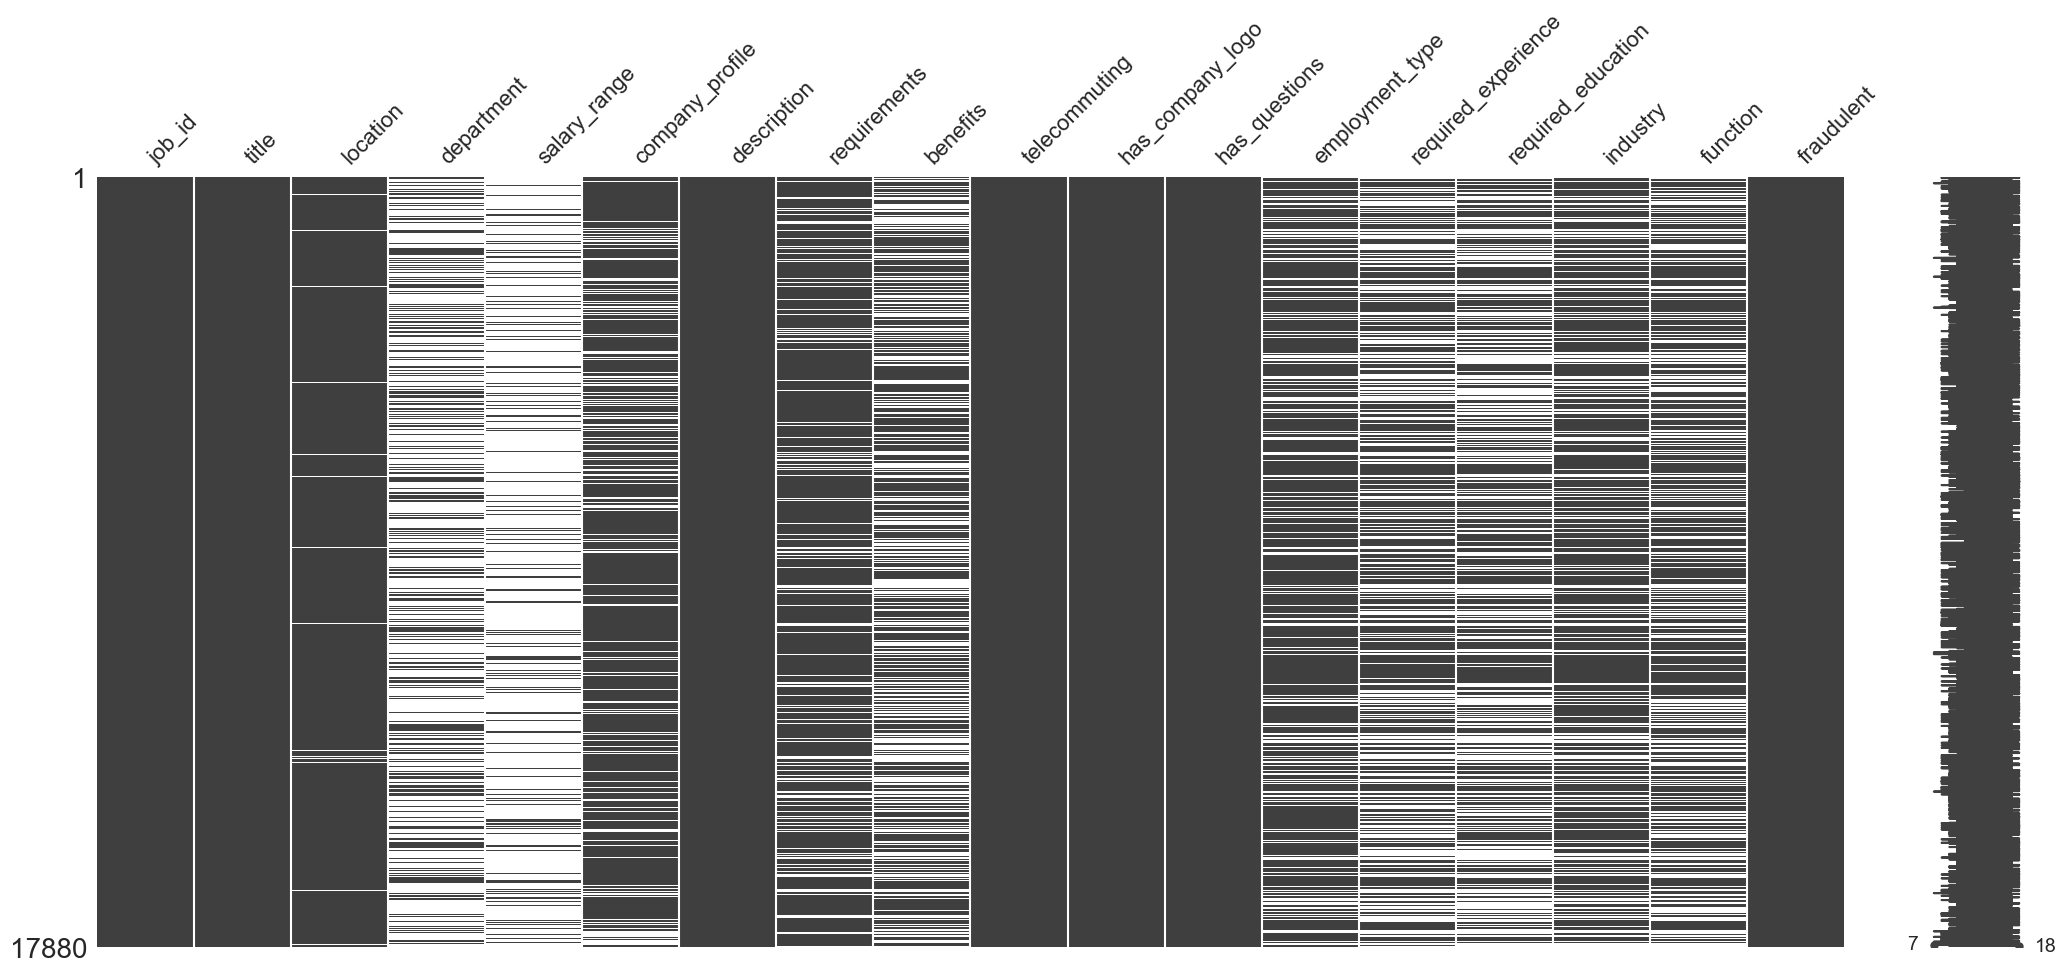

In [36]:
# пропущені значення
msno.matrix(df)

There are 528001 words in the combination of all available job titles.


(np.float64(-0.5), np.float64(1599.5), np.float64(799.5), np.float64(-0.5))

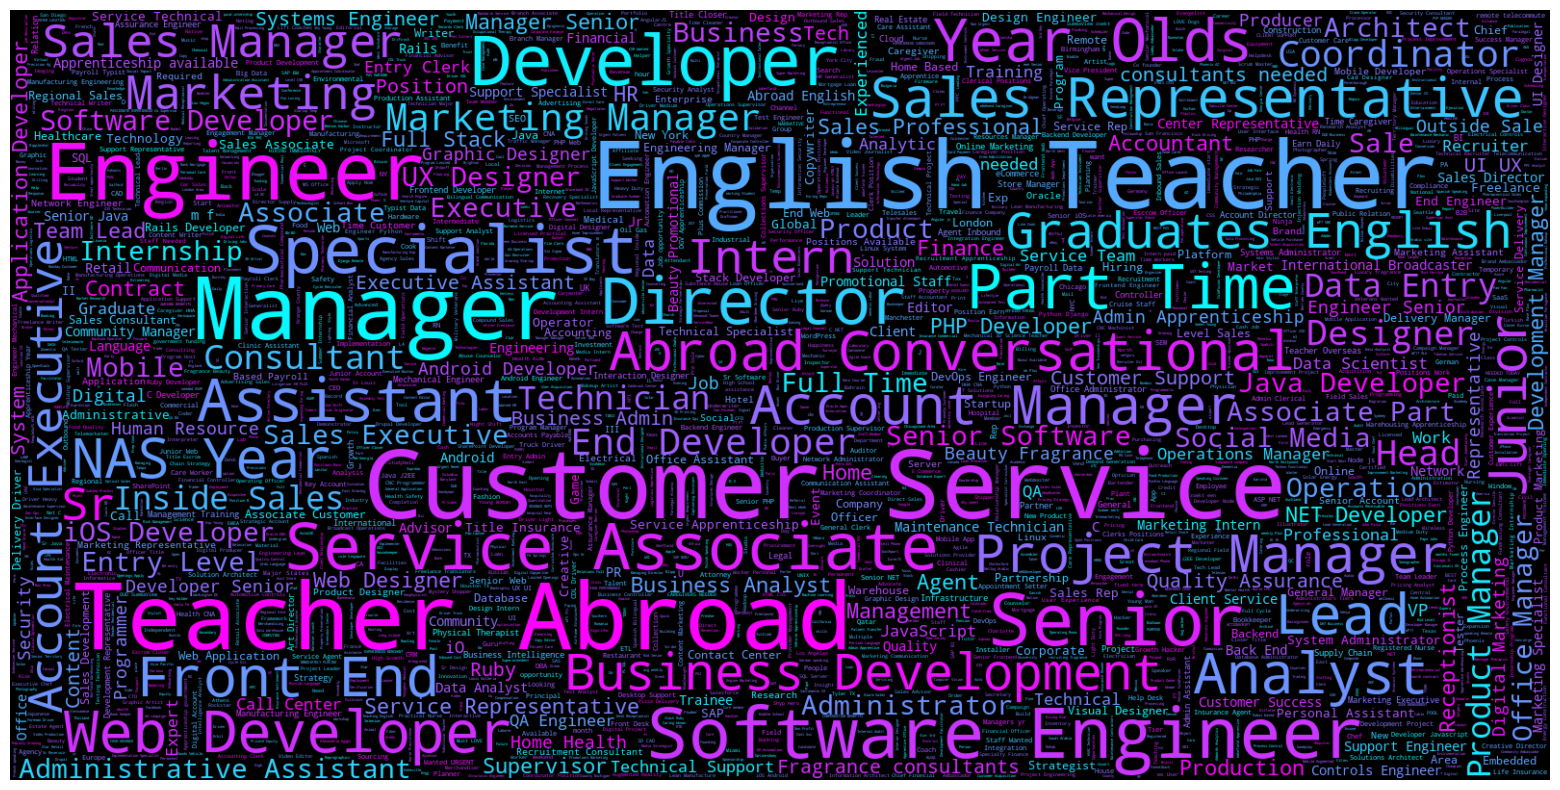

In [37]:
# генеруємо хмару слів на основі заголовків вакансій
text = " ".join(title for title in df.title)
print ("There are {} words in the combination of all available job titles.".format(len(text)))
stopwords=set(STOPWORDS)
wordcloud = WordCloud(background_color="black",max_font_size=100, max_words=10000,width=1600, height=800,stopwords=stopwords,colormap=matplotlib.cm.cool).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")

In [38]:
# визначаємо фічі, редагуємо пропущені значення
df.drop('job_id', axis=1, inplace=True)
text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']
bin_features = ['telecommuting', 'has_company_logo', 'has_questions']
cat_features = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

df.isnull().sum()


title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [39]:
for feature_name in text_features[1:]:
    df[feature_name].fillna('Unspecified', inplace=True)
    
df.isnull().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile            0
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [40]:
location = df['location'].copy()
#splitting location
location_splitted = list(location.str.split(', ').values)
for loc_ind, loc in enumerate(location_splitted):
    if loc is np.nan:
        location_splitted[loc_ind] = ['Unpecified'] * 3
    else:
        for el_ind, el in enumerate(loc):
            if el == '':
                loc[el_ind] = 'Unpecified'
                
location_splitted = list(map(lambda loc: list(loc), location_splitted))
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        location_splitted[loc_ind] = loc[:2] + [', '.join(loc[2:])]
    if len(loc) < 3:
        location_splitted[loc_ind] += ['Unpecified'] * 2
        
data_location = pd.DataFrame(location_splitted, columns=['country', 'state', 'city'])
cat_features += ['country', 'state', 'city']
df= pd.concat([df, data_location], axis=1)
df.drop('location', axis=1, inplace=True)
df.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
0,Marketing Intern,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York
1,Customer Service - Cloud Video Production,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,Unpecified,Auckland
2,Commissioning Machinery Assistant (CMA),NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever
3,Account Executive - Washington DC,Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,Bill Review Manager,NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth


In [41]:
salary_range = df.salary_range.copy()
salary_range.fillna('0-0', inplace=True)
salary_range_sep = list(salary_range.str.split('-').values)
salary_range_sep[5538] = ['40000', '40000']
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        error_range_inds += [range_ind]
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']
data_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])

num_features = ['min_salary', 'max_salary']
df = pd.concat([df, data_salary_range], axis=1)
df.drop('salary_range', axis=1, inplace=True)
df.head()


,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city,min_salary,max_salary
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York,0,0
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,Unpecified,Auckland,0,0
2,Commissioning Machinery Assistant (CMA),NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever,0,0
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,0,0
4,Bill Review Manager,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,0,0


In [42]:
df.fillna('Unspecified', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   department           17880 non-null  object
 2   company_profile      17880 non-null  object
 3   description          17880 non-null  object
 4   requirements         17880 non-null  object
 5   benefits             17880 non-null  object
 6   telecommuting        17880 non-null  int64 
 7   has_company_logo     17880 non-null  int64 
 8   has_questions        17880 non-null  int64 
 9   employment_type      17880 non-null  object
 10  required_experience  17880 non-null  object
 11  required_education   17880 non-null  object
 12  industry             17880 non-null  object
 13  function             17880 non-null  object
 14  fraudulent           17880 non-null  int64 
 15  country              17880 non-null  object
 16  stat

In [43]:
# чистка текстів
def clean_text(data):
    description_list = []
    for description in data:
        description = re.sub("[^a-zA-Z]"," ",description)
        description = description.lower()
        description = nlp.word_tokenize(description)
        description = [word for word in description if not word in stopwords]
        lemma = nlp.WordNetLemmatizer()
        description = [lemma.lemmatize(word) for word in description ]
        description =" ".join(description)
        description_list.append(description)
    return description_list

In [44]:
import nltk
nltk.download('punkt_tab')

df['description_cleaned']= clean_text(df.description)
df['company_profile_cleaned']=clean_text(df.company_profile)
df['requirements_cleaned']= clean_text(df.requirements)
df['benefits_cleaned']=clean_text(df.benefits)

df

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\111\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,...,fraudulent,country,state,city,min_salary,max_salary,description_cleaned,company_profile_cleaned,requirements_cleaned,benefits_cleaned
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,...,0,US,NY,New York,0,0,food fast growing james beard award winning on...,re food ve created groundbreaking award winnin...,experience content management system major plu...,unspecified
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,...,0,NZ,Unpecified,Auckland,0,0,organised focused vibrant awesome passion cust...,second world cloud video production service se...,expect key responsibility will communicate cli...,will usthrough part second team will gain expe...
2,Commissioning Machinery Assistant (CMA),Unspecified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,Unspecified,...,0,US,IA,Wever,0,0,client located houston actively seeking experi...,valor service provides workforce solution meet...,implement pre commissioning commissioning proc...,unspecified
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,...,0,US,DC,Washington,0,0,company esri environmental system research ins...,passion improving quality life geography heart...,education bachelor s master s gi business admi...,culture anything corporate collaborative creat...
4,Bill Review Manager,Unspecified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,...,0,US,FL,Fort Worth,0,0,job title itemization review managerlocation f...,spotsource solution llc global human capital m...,qualification rn license state texasdiploma ba...,full benefit offered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,...,0,CA,ON,Toronto,0,0,case first time ve visited website vend award ...,vend looking awesome new talent come join u ll...,ace role will eat comprehensive statement work...,expect u open culture openly share result inpu...
17876,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,...,0,US,PA,Philadelphia,0,0,payroll accountant will focus primarily payrol...,weblinc e commerce platform service provider f...,b b s accounting desire fun love genuine passi...,health amp wellnessmedical planprescription dr...
17877,Project Cost Control Staff Engineer - Cost Con...,Unspecified,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,Unspecified,0,0,0,Full-time,...,0,US,TX,Houston,0,0,experienced project cost control staff enginee...,provide full time permanent position many medi...,least year professional experience ability wor...,unspecified
17878,Graphic Designer,U

In [45]:
# визначаємо довжини комірок
df['title_length']=df['title'].astype(str).str.split(' ').apply(len)
df['company_profile_length']=df['company_profile_cleaned'].astype(str).str.split(' ').apply(len)
df['benefits_length']=df['benefits_cleaned'].astype(str).str.split(' ').apply(len)
df['description_length']=df['description_cleaned'].astype(str).str.split(' ').apply(len)
df['requirements_length']=df['requirements_cleaned'].astype(str).str.split(' ').apply(len)

df

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,...,max_salary,description_cleaned,company_profile_cleaned,requirements_cleaned,benefits_cleaned,title_length,company_profile_length,benefits_length,description_length,requirements_length
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,...,0,food fast growing james beard award winning on...,re food ve created groundbreaking award winnin...,experience content management system major plu...,unspecified,2,92,1,84,76
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,...,0,organised focused vibrant awesome passion cust...,second world cloud video production service se...,expect key responsibility will communicate cli...,will usthrough part second team will gain expe...,6,157,111,208,133
2,Commissioning Machinery Assistant (CMA),Unspecified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,Unspecified,...,0,client located houston actively seeking experi...,valor service provides workforce solution meet...,implement pre commissioning commissioning proc...,unspecified,4,81,1,31,126
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,...,0,company esri environmental system research ins...,passion improving quality life geography heart...,education bachelor s master s gi business admi...,culture anything corporate collaborative creat...,5,58,77,230,124
4,Bill Review Manager,Unspecified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,...,0,job title itemization review managerlocation f...,spotsource solution llc global human capital m...,qualification rn license state texasdiploma ba...,full benefit offered,3,169,3,132,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,...,0,case first time ve visited website vend award ...,vend looking awesome new talent come join u ll...,ace role will eat comprehensive statement work...,expect u open culture openly share result inpu...,5,173,81,134,115
17876,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,...,0,payroll accountant will focus primarily payrol...,weblinc e commerce platform service provider f...,b b s accounting desire fun love genuine passi...,health amp wellnessmedical planprescription dr...,2,221,53,118,66
17877,Project Cost Control Staff Engineer - Cost Con...,Unspecified,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,Unspecified,0,0,0,Full-time,...,0,experienced project cost control staff enginee...,provide full time permanent position many medi...,least year professional experience ability wor...,unspecified,11,23,1,123,119
17878,Graphi

In [46]:
label=LabelEncoder()
df['employment_type']=label.fit_transform(df['employment_type'])
df['required_experience']=label.fit_transform(df['required_experience'])
df['required_education']=label.fit_transform(df['required_education'])
df['industry']=label.fit_transform(df['industry'])
df['function']=label.fit_transform(df['function'])
df['country']=label.fit_transform(df['country'])
df['state']=label.fit_transform(df['state'])
df['city']=label.fit_transform(df['city'])

In [47]:
X=df.drop(['title','department','company_profile','description','requirements','benefits','description_cleaned','company_profile_cleaned','requirements_cleaned','benefits_cleaned','fraudulent'],axis=1)
y=df.fraudulent

In [48]:
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [49]:
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [50]:
def roc_plotter(model_object,model_name):     
        model_object.fit(X_train, y_train)
        y_pred=model_object.predict(X_test)
        ns_probs = [0 for _ in range(len(y_test))]

        # predict probabilities
        model_probs = model_object.predict_proba(X_test)[:, 1]

        # calculate scores
        ns_auc = roc_auc_score(y_test, ns_probs)
        model_auc = roc_auc_score(y_test, model_probs)
    
        fig = plt.figure(figsize=(12,5))

        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, model_probs)
        # plot the roc curve for the model
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        score= accuracy_score(y_test, y_pred)
        txt1='ROC AUC = {}'.format(round(model_auc,2))
        txt2='Accuracy = {}%'.format(round(score*100,2))
        
        plt.text(0.3,0.2,model_name,fontsize=25, fontweight='bold',color='red')
        plt.text(0.3,0.1,txt1,bbox={'facecolor': 'orange','pad': 10},fontsize=15)
        plt.text(0.5,0.1,txt2,bbox={'facecolor': 'red', 'pad': 10},fontsize=15,color='white')
        plt.tight_layout()


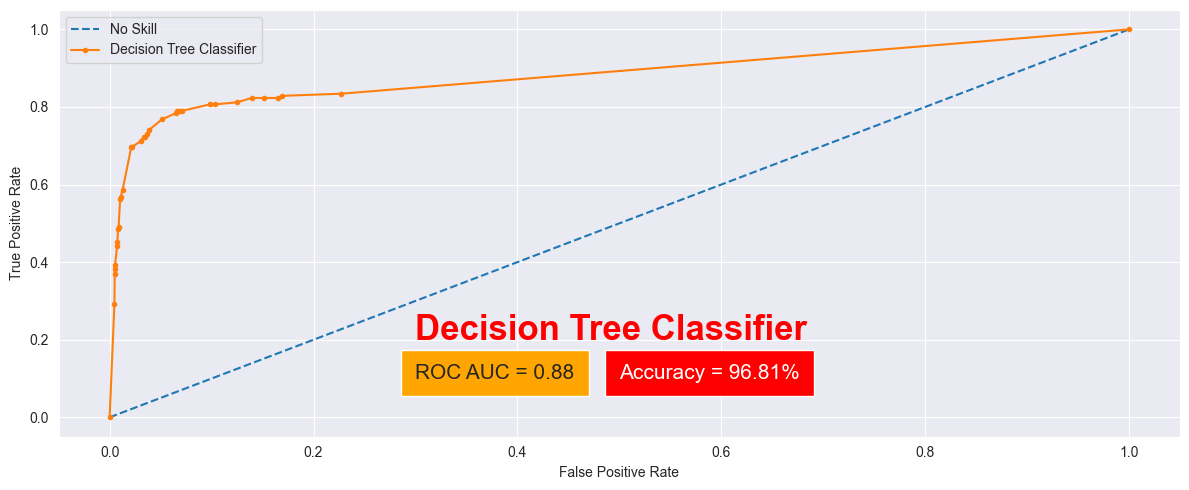

In [70]:
dtmodel=DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
roc_plotter(dtmodel,'Decision Tree Classifier')

In [71]:
dtmodel.fit(X_train, y_train)
y_pred = dtmodel.predict(X_test)

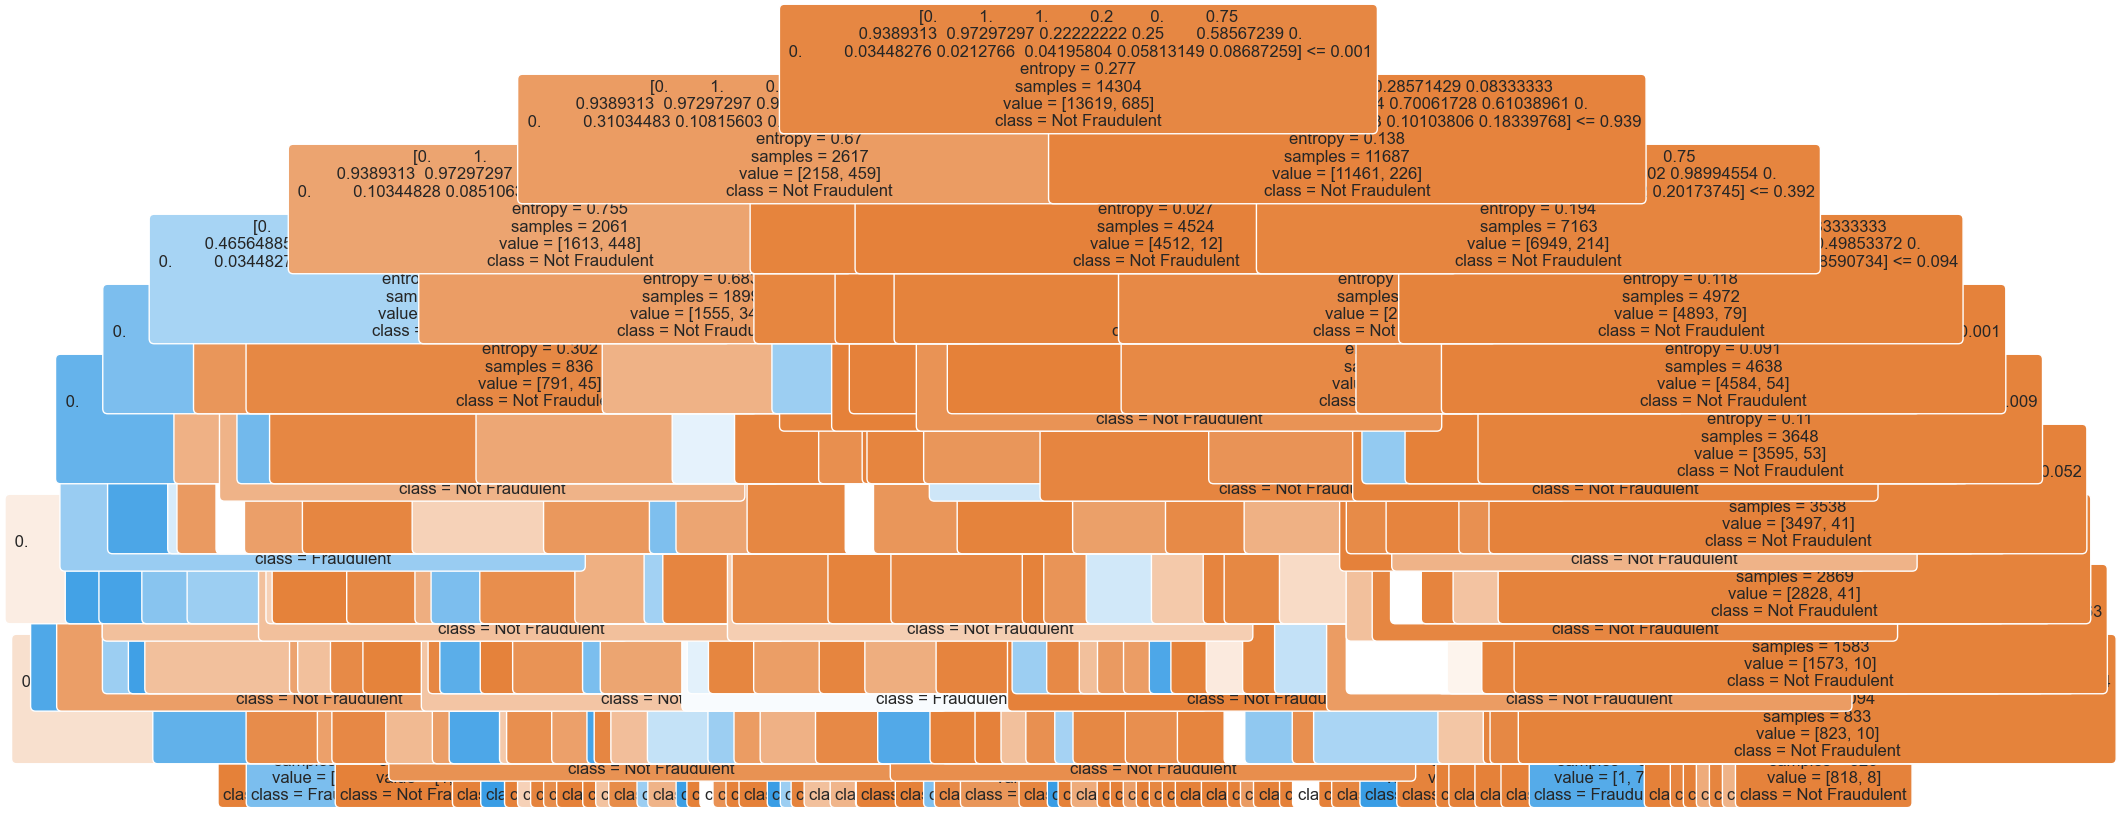

In [72]:
plt.figure(figsize=(20, 10))
plot_tree(dtmodel, filled=True, feature_names=X_train, class_names=['Not Fraudulent', 'Fraudulent'], rounded=True, fontsize=12)
plt.show()

In [74]:

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[3360   35]
 [  79  102]]


In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3395
           1       0.74      0.56      0.64       181

    accuracy                           0.97      3576
   macro avg       0.86      0.78      0.81      3576
weighted avg       0.97      0.97      0.97      3576



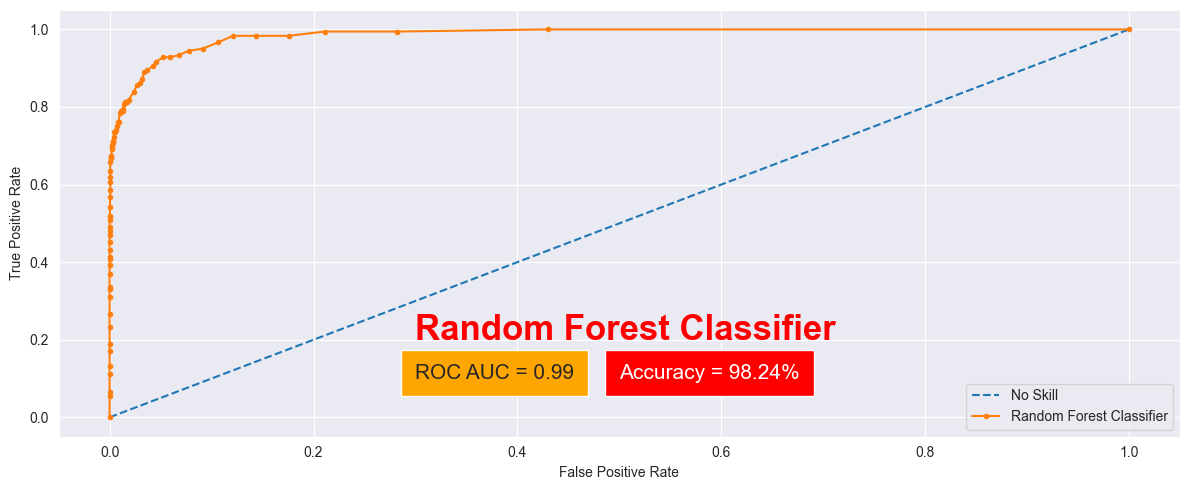

In [76]:
rfmodel=RandomForestClassifier()
roc_plotter(rfmodel,'Random Forest Classifier')

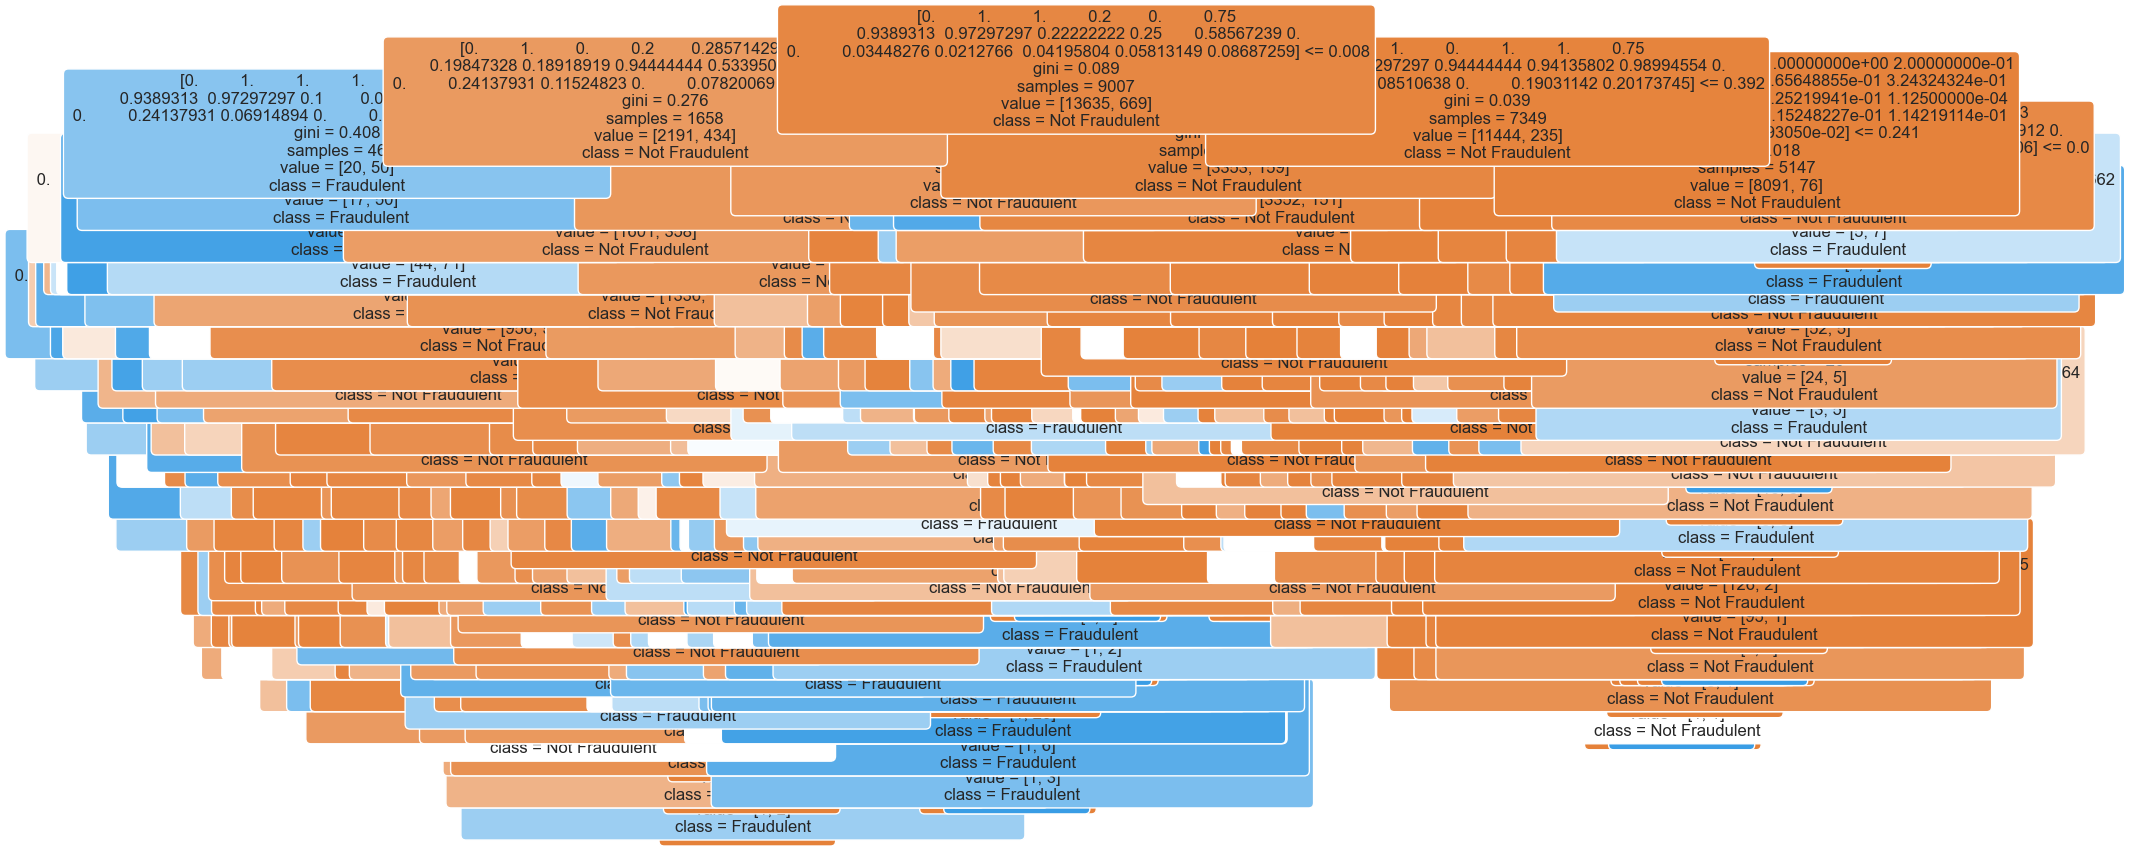

In [58]:
# Натренувати модель
rfmodel.fit(X_train, y_train)

# Вибрати перше дерево в лісі
tree = rfmodel.estimators_[0]

# Візуалізувати перше дерево
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train, class_names=['Not Fraudulent', 'Fraudulent'], rounded=True, fontsize=12)
plt.show()

In [78]:
y_pred = rfmodel.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm2)

Confusion matrix

 [[3391    4]
 [  59  122]]


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.97      0.67      0.79       181

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

